# Data Import, Cleaning and Map Creation

## Load packages

In [4]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import geopandas as gpd
!pip install fuzzywuzzy
from fuzzywuzzy import process, fuzz
from shapely import wkt

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Import Drug NDC JSON file

In [6]:
# json file download link: https://open.fda.gov/apis/drug/ndc/download/
data = json.load(open('/content/drugs.json'))
# extract results section
js_df = pd.DataFrame(data['results'])
# export json to csv file
js_df.to_csv('/content/drugs_df.csv')

In [7]:
df2 = pd.read_csv('/content/drugs_df.csv', index_col=0)

In [9]:
# drop unwanted columns and created new dataframe
newdf = df2.drop(columns=['finished','packaging','listing_expiration_date','openfda','marketing_category','spl_id','product_type','marketing_start_date','product_id','application_number','active_ingredients', 'pharm_class','marketing_end_date','brand_name_suffix'])
newdf.sample(5)


,product_ndc,generic_name,labeler_name,brand_name,dosage_form,route,brand_name_base,dea_schedule
94804,73408-936,water solution,Crane Safety LLC,Crane Safety Eye Wash,SOLUTION,['OPHTHALMIC'],Crane Safety Eye Wash,NaN
56264,49527-029,"OCTINOXATE, OCTISALATE, TITANIUM DIOXIDE, and ...",CLINIQUE LABORATORIES LLC,NaN,CREAM,NaN,NaN,NaN
101240,50090-4959,insulin aspart,A-S Medication Solutions,.Insulin Aspart Protamine and Insulin Aspart,"INJECTION, SUSPENSION",['SUBCUTANEOUS'],.Insulin Aspart Protamine and Insulin Aspart,NaN
14953,83636-603,Sturgeon extract,"Sturgeonbio Co.,Ltd.",The Zoeun Skin Sturgeon Gel,GEL,['TOPICAL'],The Zoeun Skin Sturgeon Gel,NaN
74278,0220-1057,CALENDULA OFFICINALIS FLOWERING TOP,Boiron,Calendula officinalis,PELLET,['ORAL'],Calendula officinalis,NaN


In [10]:
# clean values in new dataframe
newdf = newdf.apply(lambda x: x.str.replace('[^\w\s]', ''))

<ipython-input-10-6adb9094762b>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  newdf = newdf.apply(lambda x: x.str.replace('[^\w\s]', ''))


In [11]:
newdf.to_csv('/content/clean_drugsummary.csv')

## Import geospatial map of United States and Opioid Prescribing data sets

In [47]:
df_spatial = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')

In [49]:
df_op = pd.read_csv('/content/Medicare_Part_D_Opioid_Prescribing_Rates_by_Geography_2021.csv')

### Rename columns with state names

In [50]:
op_state = df_op.rename(columns={"Prscrbr_Geo_Desc":"state"})

In [51]:
spat_state = df_spatial.rename(columns={"name":"state"})

### Preview data

In [52]:
op_state.sample(5)

,Year,Prscrbr_Geo_Lvl,state,Breakout_Type,Breakout,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,LA_Tot_Opioid_Clms,LA_Opioid_Prscrbng_Rate,LA_Opioid_Prscrbng_Rate_5Y_Chg,LA_Opioid_Prscrbng_Rate_1Y_Chg
1256,2014,State,Mississippi,Rural/Urban,Rural,"3,622","2,948","623,973","10,338,881",6.04%,NaN,-0.20%,"45,379",7.27%,NaN,0.20%
1058,2015,State,Wyoming,Totals,Overall,"1,760","1,363","107,085","1,718,579",6.23%,NaN,-0.02%,"17,067",15.94%,NaN,0.07%
826,2017,State,Tennessee,Rural/Urban,Urban,"20,546","15,718","1,941,118","29,132,238",6.66%,NaN,-0.31%,"252,406",13.00%,NaN,-1.23%
946,2016,State,Wyoming,Rural/Urban,Rural,"1,087",843,"67,545","1,090,330",6.19%,NaN,-0.18%,"11,273.5",16.69%,NaN,-0.27%
912,2016,State,Kansas,Rural/Urban,Rural,"2,781","2,235","323,867","5,870,607",5.52%,NaN,-0.30%,"52,993",16.36%,NaN,0.14%


In [53]:
spat_state.sample(5)

,id,state,density,geometry
35,39,Ohio,281.90,"POLYGON ((-80.51860 41.97880, -80.51860 40.636..."
17,21,Kentucky,110.00,"POLYGON ((-83.90335 38.76931, -83.67879 38.632..."
11,15,Hawaii,214.10,"MULTIPOLYGON (((-155.63484 18.94827, -155.8813..."
16,20,Kansas,35.09,"POLYGON ((-101.90605 40.00163, -95.30634 40.00..."
48,54,West Virginia,77.06,"POLYGON ((-80.51860 40.63695, -80.51860 39.722..."


In [54]:
spat_state.dtypes

id            object
state         object
density      float64
geometry    geometry
dtype: object

<Axes: >

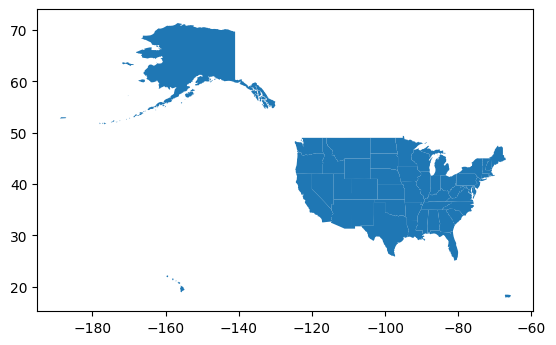

In [55]:
spat_state.plot()

In [66]:
op_state.dtypes

Year                                int64
Prscrbr_Geo_Lvl                    object
state                              object
Breakout_Type                      object
Breakout                           object
Tot_Prscrbrs                        int64
Tot_Opioid_Prscrbrs                 int64
Tot_Opioid_Clms                   float64
Tot_Clms                            int64
Opioid_Prscrbng_Rate              float64
Opioid_Prscrbng_Rate_5Y_Chg        object
Opioid_Prscrbng_Rate_1Y_Chg        object
LA_Tot_Opioid_Clms                 object
LA_Opioid_Prscrbng_Rate            object
LA_Opioid_Prscrbng_Rate_5Y_Chg     object
LA_Opioid_Prscrbng_Rate_1Y_Chg     object
dtype: object

### Remove special characters from data sets

In [57]:
op_state['Tot_Prscrbrs'] = op_state['Tot_Prscrbrs'].str.replace('[,]', '')

<ipython-input-57-bdbe679ea82a>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  op_state['Tot_Prscrbrs'] = op_state['Tot_Prscrbrs'].str.replace('[,]', '')


In [61]:
op_state['Tot_Opioid_Prscrbrs'] = op_state['Tot_Opioid_Prscrbrs'].str.replace('[,]', '')

op_state['Tot_Opioid_Clms'] = op_state['Tot_Opioid_Clms'].str.replace('[,]', '')

op_state['Tot_Clms'] = op_state['Tot_Clms'].str.replace('[,]', '')

<ipython-input-61-d6dcf6eb8c94>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  op_state['Tot_Opioid_Prscrbrs'] = op_state['Tot_Opioid_Prscrbrs'].str.replace('[,]', '')
<ipython-input-61-d6dcf6eb8c94>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  op_state['Tot_Opioid_Clms'] = op_state['Tot_Opioid_Clms'].str.replace('[,]', '')
<ipython-input-61-d6dcf6eb8c94>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  op_state['Tot_Clms'] = op_state['Tot_Clms'].str.replace('[,]', '')


In [64]:
op_state['Opioid_Prscrbng_Rate'] = op_state['Opioid_Prscrbng_Rate'].str.replace('[%]', '')

<ipython-input-64-5b9696aedbaf>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  op_state['Opioid_Prscrbng_Rate'] = op_state['Opioid_Prscrbng_Rate'].str.replace('[%]', '')


### Convert column types

In [62]:
op_state['Tot_Prscrbrs'] = op_state['Tot_Prscrbrs'].astype(int)

In [63]:
op_state['Tot_Opioid_Clms'] = op_state['Tot_Opioid_Clms'].astype(float)
op_state['Tot_Opioid_Prscrbrs'] = op_state['Tot_Opioid_Prscrbrs'].astype(int)
op_state['Tot_Clms'] = op_state['Tot_Clms'].astype(int)


In [65]:
op_state['Opioid_Prscrbng_Rate'] = op_state['Opioid_Prscrbng_Rate'].astype(float)

### Match columns on state and merge

In [68]:
## function to get best match
def get_best_match(name, choices, threshold=90):
    match_data = process.extractOne(name, choices)
    if match_data:
        match, score, _ = match_data  # Unpack three elements, ignoring the index
        return match if score >= threshold else None
    return None

In [69]:
## apply fuzzy matching
op_state['state'] = op_state['state'].apply(lambda x: get_best_match(x, spat_state['state']))

In [70]:
## merge the dataframes based on the matched names
merged = pd.merge(op_state, spat_state, left_on='state', right_on='state', how='left')

In [71]:
len(merged)

1512

In [72]:
merged.dropna(inplace=True)

In [ ]:
merged.dropna(subset=['geometry'])

In [74]:
merged.dtypes

Year                                 int64
Prscrbr_Geo_Lvl                     object
state                               object
Breakout_Type                       object
Breakout                            object
Tot_Prscrbrs                         int64
Tot_Opioid_Prscrbrs                  int64
Tot_Opioid_Clms                    float64
Tot_Clms                             int64
Opioid_Prscrbng_Rate               float64
Opioid_Prscrbng_Rate_5Y_Chg         object
Opioid_Prscrbng_Rate_1Y_Chg         object
LA_Tot_Opioid_Clms                  object
LA_Opioid_Prscrbng_Rate             object
LA_Opioid_Prscrbng_Rate_5Y_Chg      object
LA_Opioid_Prscrbng_Rate_1Y_Chg      object
id                                  object
density                            float64
geometry                          geometry
dtype: object

In [76]:
merged.sample(5)

,Year,Prscrbr_Geo_Lvl,state,Breakout_Type,Breakout,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,LA_Tot_Opioid_Clms,LA_Opioid_Prscrbng_Rate,LA_Opioid_Prscrbng_Rate_5Y_Chg,LA_Opioid_Prscrbng_Rate_1Y_Chg,id,density,geometry
2,2021,State,Arizona,Totals,Overall,27033,16049,1261909.0,26432513,4.77,-1.82%,-0.18%,"153,263",12.15%,-4.21%,-0.70%,04,57.050,"POLYGON ((-109.04250 37.00026, -109.04798 31.3..."
162,2021,State,Wyoming,Rural/Urban,Urban,780,501,30283.0,699723,4.33,-1.23%,-0.15%,"4,051.5",13.38%,-1.19%,-1.51%,56,5.851,"POLYGON ((-109.08084 45.00207, -105.91517 45.0..."
90,2021,State,North Dakota,Rural/Urban,Rural,1047,747,47402.0,1632311,2.90,-0.76%,-0.06%,"6,330.5",13.35%,-4.06%,-0.06%,38,9.916,"POLYGON ((-97.22874 49.00024, -97.09730 48.682..."
459,2019,State,Hawaii,Rural/Urban,Urban,3612,2212,94859.0,3090543,3.07,-0.34%,-0.10%,"13,294.5",14.02%,-1.13%,0.11%,15,214.100,"MULTIPOLYGON (((-155.63484 18.94827, -155.8813..."
634,2018,State,Louisiana,Rural/Urban,Urban,16163,11533,1257412.0,22445828,5.60,-1.03%,-0.24%,"112,203",8.92%,-0.13%,-0.42%,22,105.000,"POLYGON ((-93.60849 33.01853, -91.16577 33.002..."


In [ ]:
len(merged)

1512

In [77]:
merged_map = merged

In [78]:
merged_map[['Opioid_Prscrbng_Rate', 'geometry']].sort_values(by=['Opioid_Prscrbng_Rate'], ascending=False)

,Opioid_Prscrbng_Rate,geometry
604,7.40,"POLYGON ((-112.16436 41.99523, -111.04706 42.0..."
652,7.21,"POLYGON ((-100.08771 37.00026, -94.61624 37.00..."
616,7.04,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
436,6.92,"POLYGON ((-112.16436 41.99523, -111.04706 42.0..."
504,6.90,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
...,...,...
502,0.96,"POLYGON ((-66.44834 17.98433, -66.77148 18.006..."
222,0.84,"POLYGON ((-66.44834 17.98433, -66.77148 18.006..."
334,0.84,"POLYGON ((-66.44834 17.98433, -66.77148 18.006..."
166,0.82,"POLYGON ((-66.44834 17.98433, -66.77148 18.006..."


In [79]:
# Drop values with the word 'none'
for x in merged_map.index:
  if merged_map.loc[x, "geometry"] == 'none' or merged_map.loc[x, "Opioid_Prscrbng_Rate"] == 'none':
    merged_map.drop(x, inplace = True)

In [80]:
merged_map.dropna(inplace=True)

### Map merged dataframe

In [28]:
merged_map['geometry'] = merged_map['geometry'].apply(wkt.loads)

In [81]:
gdf = gpd.GeoDataFrame(merged_map, geometry='geometry')

In [83]:
fig = gdf.plot('Opioid_Prscrbng_Rate', legend=True)

Output hidden; open in https://colab.research.google.com to view.